# Quantum Lattice Boltzmann Circuit Visualization
This notebook visualizes the quantum circuits used in different stages of the QLBM simulation.

In [96]:
import numpy as np
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
import importlib
import qlbmlib
importlib.reload(qlbmlib)

# Set up basic parameters for visualization
sites_1d = (8,8)  # Small 1D example for clarity
links = [[0,0], [-1,0], [1,0], [-1,-1], [2,1]]  # D1Q3 lattice
weights = [1/5, 1/5, 1/5, 1/5, 1/5]
speed_of_sound = 1/np.sqrt(3)
zero_velocity = np.zeros((1,) + sites_1d)

## 1. Link Encoding Circuit
The link encoding circuit prepares the superposition of different lattice directions.

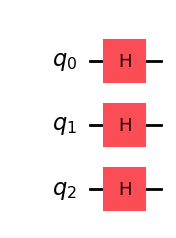

In [97]:
# Create and display link encoding circuit
num_links = len(links)
link_qubits = int(np.ceil(np.log2(num_links)))

encoding_circuit = qlbmlib.encode_links(link_qubits, num_links)
encoding_circuit.draw('mpl', fold=40, filename='experiments/figures/encoding_circuit.png')

## 2. Collision Circuit
The collision circuit applies a controlled diagonal unitary operation based on the collision matrix.

In [98]:
def collision_nonuniform_viz(site_qubits: int, link_qubits: int) -> QuantumCircuit:
    """Create a simplified collision circuit for visualization"""
    num_qubits = site_qubits + link_qubits + 1
    qc = QuantumCircuit(num_qubits)
    
    ancilla = num_qubits - 1
    target_qubits = list(range(ancilla))

    gate1 = QuantumCircuit(len(target_qubits)).to_gate(label='Diagonal 1')
    gate2 = QuantumCircuit(len(target_qubits)).to_gate(label='Diagonal 2')

    qc.h(ancilla)
    qc.append(gate1.control(ctrl_state='0'), [ancilla] + target_qubits)
    qc.append(gate2.control(ctrl_state='1'), [ancilla] + target_qubits)
    qc.h(ancilla)

    return qc

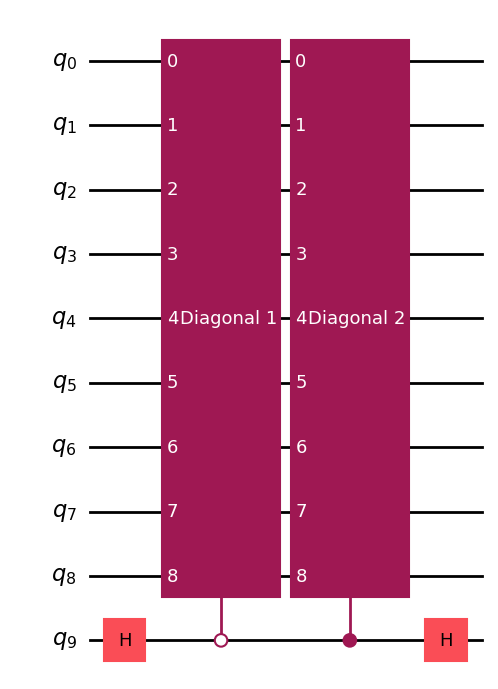

In [99]:
collision_circuit = collision_nonuniform_viz(6, link_qubits)
collision_circuit.draw('mpl', fold=40, filename='experiments/figures/collision_circuit.png')

## 3. Propagation Circuit
The propagation circuit performs controlled shift operations based on the lattice velocities.

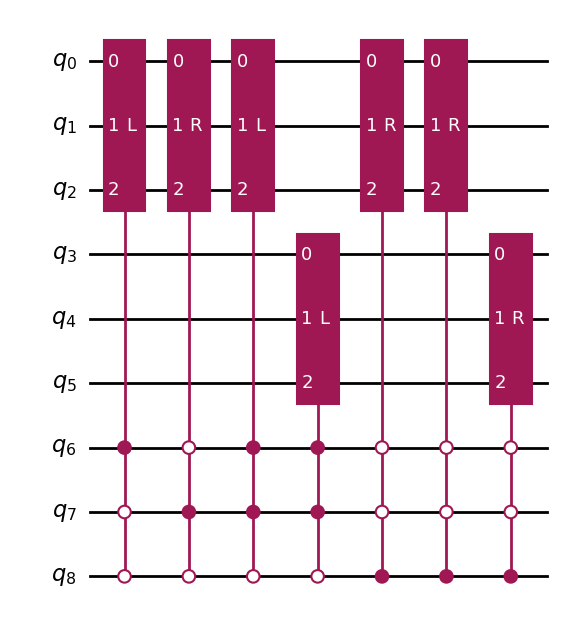

In [100]:
# Create and display propagation circuit
propagation_circuit = qlbmlib.propagation([3,3], link_qubits, links)
propagation_circuit.draw('mpl', fold=40, filename='experiments/figures/propagation_circuit.png')

## 4. Quantum Macros Circuit
The quantum macros circuit combines the link qubit information using Hadamard gates.

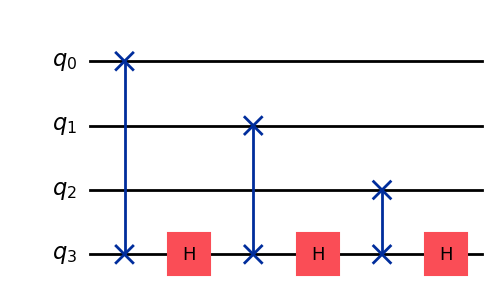

In [101]:
# Create and display macros circuit
macros_circuit = qlbmlib.macros(link_qubits)
macros_circuit.draw('mpl', fold=40, filename='experiments/figures/macros_circuit.png')

## 5. R and L Gates
The R (right) and L (left) gates are used for implementing qubit rotations. These gates use multi-controlled X gates to create the rotation operations.

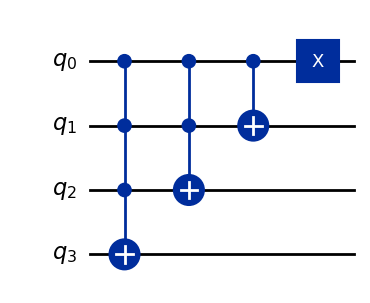

In [102]:
# Create and display R gate circuit for 4 qubits
qc_r = QuantumCircuit(4)
for i in range(4-1, -1, -1):
    if i == 0:
        qc_r.x(i)
    else:
        controls = list(range(0, i))
        qc_r.mcx(controls, i)

qc_r.draw('mpl', fold=40, filename='experiments/figures/r_gate.png')

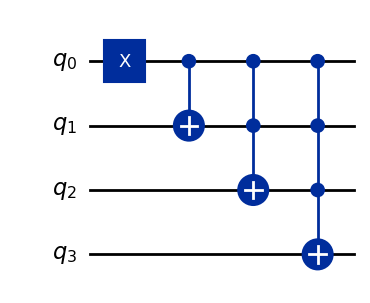

In [103]:
# Create and display L gate circuit for 4 qubits
qc_l = QuantumCircuit(4)
for i in range(4):
    if i == 0:
        qc_l.x(i)
    else:
        controls = list(range(0, i))
        qc_l.mcx(controls, i)

qc_l.draw('mpl', fold=40, filename='experiments/figures/l_gate.png')

## 5. Complete Evolution Circuit
Here's how all the components come together for one iteration of the quantum simulation.

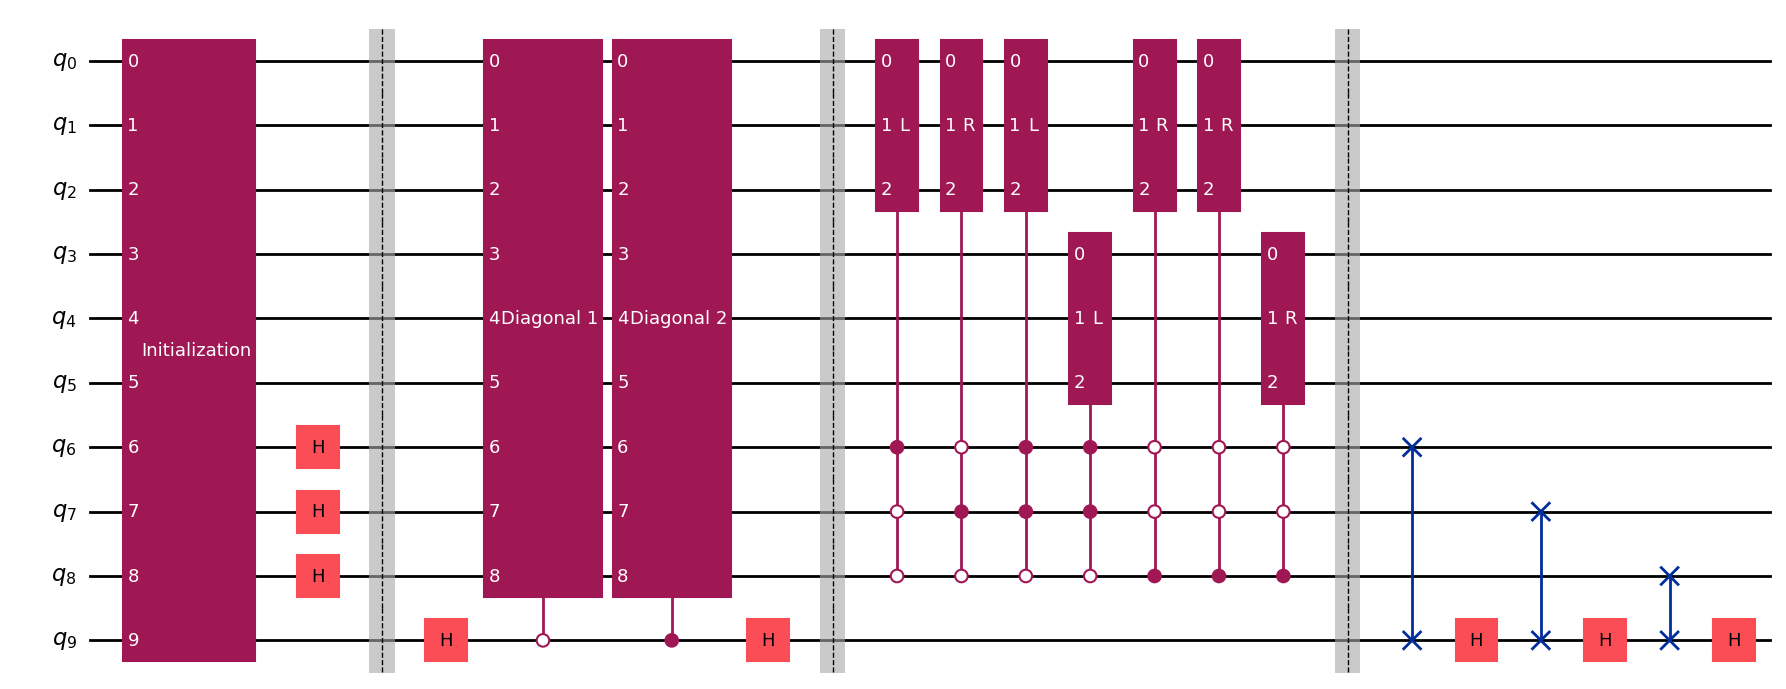

In [110]:
# Create a small example initial state
initial_density = np.ones((8,8)) / np.sqrt(8)  # Normalized uniform distribution
site_qubits = 6
# Create complete circuit
qc = QuantumCircuit(np.sum(site_qubits) + link_qubits + 1)

encode_dummy = QuantumCircuit(site_qubits + link_qubits + 1).to_gate(label='Initialization')

# Add components
qc.append(encode_dummy, list(range(site_qubits + link_qubits + 1)))
qc.compose(qlbmlib.encode_links(link_qubits, num_links), 
          qubits=list(range(site_qubits, site_qubits + link_qubits)), 
          inplace=True)
qc.barrier()
qc.compose(collision_nonuniform_viz(site_qubits, link_qubits), 
          inplace=True)
qc.barrier()
qc.compose(qlbmlib.propagation([3,3], link_qubits, links),
          qubits=list(range(0, site_qubits + link_qubits)),
          inplace=True)
qc.barrier()
qc.compose(qlbmlib.macros(link_qubits),
          qubits=list(range(site_qubits, site_qubits + link_qubits + 1)),
          inplace=True)

# Draw complete circuit
qc.draw('mpl', fold=100, filename='experiments/figures/complete_circuit.png')